#  Exploratory Data Analysis of Aphex Twin's Music Using Spotify Metrics


This notebook analyzes Aphex Twin’s music using Spotify’s audio features. It explores various metrics, such as energy, acousticness, and Danceability, to understand their relationship with track characteristics and popularity.

The analysis involves calculating custom "Bangerness" and "Ambientness" scores to assess track intensity and atmosphere. Additionally, the analysis examines how features such as energy and acousticness correlate with track popularity.



The initial dataset was compiled using Spotify's API, covering all available Aphex Twin tracks and their associated features. [The code used to generate this dataset can be found here](https://github.com/iftah-og/afx_eda/blob/main/spot_to_df.ipynb).

In [162]:
# Import necessary stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [211]:
# Load the dataset from the specified URL 
url = 'https://raw.githubusercontent.com/iftah-og/afx_eda/main/afx.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Track Name,Album Name,Track ID,Popularity,Tempo (BPM),Duration (s),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Release Date
0,0,Digeridoo - 2022 Remaster,Digeridoo (Expanded Edition),2Fh8MjqWLFCoiOOHQRfqgq,40,146.092,432.938,0.519,0.977,10,-8.057,0,0.0544,0.774,0.855,0.114,0.568,2024-05-31
1,1,Flap Head - 2022 Remaster,Digeridoo (Expanded Edition),24nMZbhkJNqJ70P1J81ZNx,35,136.244,420.766,0.566,0.995,1,-7.022,1,0.0503,0.151,0.886,0.399,0.592,2024-05-31
2,2,Phloam - 2022 Remaster,Digeridoo (Expanded Edition),2jft0p7lZNXkKksCFHbsKr,32,135.88,333.535,0.525,0.977,10,-8.163,0,0.131,0.000882,0.44,0.145,0.238,2024-05-31
3,3,Isoprophlex - 2022 Remaster,Digeridoo (Expanded Edition),1U3W1jTqreI3YL84sA1eCx,30,135.609,383.964,0.646,0.914,1,-9.003,0,0.073,0.234,0.768,0.039,0.339,2024-05-31
4,4,Digeridoo - Cr7E Version,Digeridoo (Expanded Edition),2Ujum3PkQL0x3QMnGoJGPf,34,142.844,445.314,0.533,0.972,7,-8.425,1,0.0521,0.765,0.906,0.123,0.415,2024-05-31


### Routine check for types

In [212]:
df.dtypes

Unnamed: 0            int64
Track Name           object
Album Name           object
Track ID             object
Popularity            int64
Tempo (BPM)          object
Duration (s)        float64
Danceability         object
Energy               object
Key                  object
Loudness             object
Mode                 object
Speechiness          object
Acousticness         object
Instrumentalness     object
Liveness             object
Valence              object
Release Date         object
dtype: object

### Numeric conversion 

In [217]:
# Ensure 'Release Date' is in datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Convert columns to numeric
numeric_cols = ['Tempo (BPM)', 'Danceability', 'Energy', 'Loudness', 'Acousticness', 
                'Instrumentalness', 'Valence', 'Speechiness','Key','Mode', 'Popularity', 'Duration (s)', 'Liveness']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure 'Release Date' is in datetime format and handle NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

df.dtypes


Unnamed: 0                       int64
Track Name                      object
Album Name                      object
Track ID                        object
Popularity                       int64
Tempo (BPM)                    float64
Duration (s)                   float64
Danceability                   float64
Energy                         float64
Key                            float64
Loudness                       float64
Mode                             int64
Speechiness                    float64
Acousticness                   float64
Instrumentalness               float64
Liveness                       float64
Valence                        float64
Release Date            datetime64[ns]
Release Date Numeric           float64
dtype: object

This section replaces all instances of 'No data' with NaN in the DataFrame and subsequently removes any rows that contain NaN values. 

In [218]:
# Replace 'No Data' with NaN
df.replace('No data', pd.NA, inplace=True)

# Drop the column 'Unnamed: 0' from the DataFrame
df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

In [232]:
df_dance = df.sort_values(['Danceability'], ascending=False).head()
df_dance[['Track Name', 'Danceability']]

,Track Name,Danceability
89,#8,0.942
80,Cow Cud Is A Twin,0.851
14,180db_ [130],0.828
24,Kladfvgbung Mischk,0.816
12,produk 29 [101],0.815


In [231]:
df_energy = df.sort_values(['Energy'], ascending=False).head()
df_energy[['Track Name', 'Energy']]

,Track Name,Energy
116,Hedphelym,0.999
64,Carn Marth,0.997
1,Flap Head - 2022 Remaster,0.995
75,Come On You Slags,0.995
9,Flap Head - Cr7E Version,0.994


In [230]:
df_valence = df.sort_values(['Valence'], ascending=False).head()
df_valence[['Track Name', 'Valence']] 

,Track Name,Valence
57,Funny Little Man,0.886
28,Bbydhyonchord,0.883
70,Acrid Avid Jam Shred,0.796
63,Fingerbib,0.787
20,s950tx16wasr10 [163.97][earth portal mix],0.743


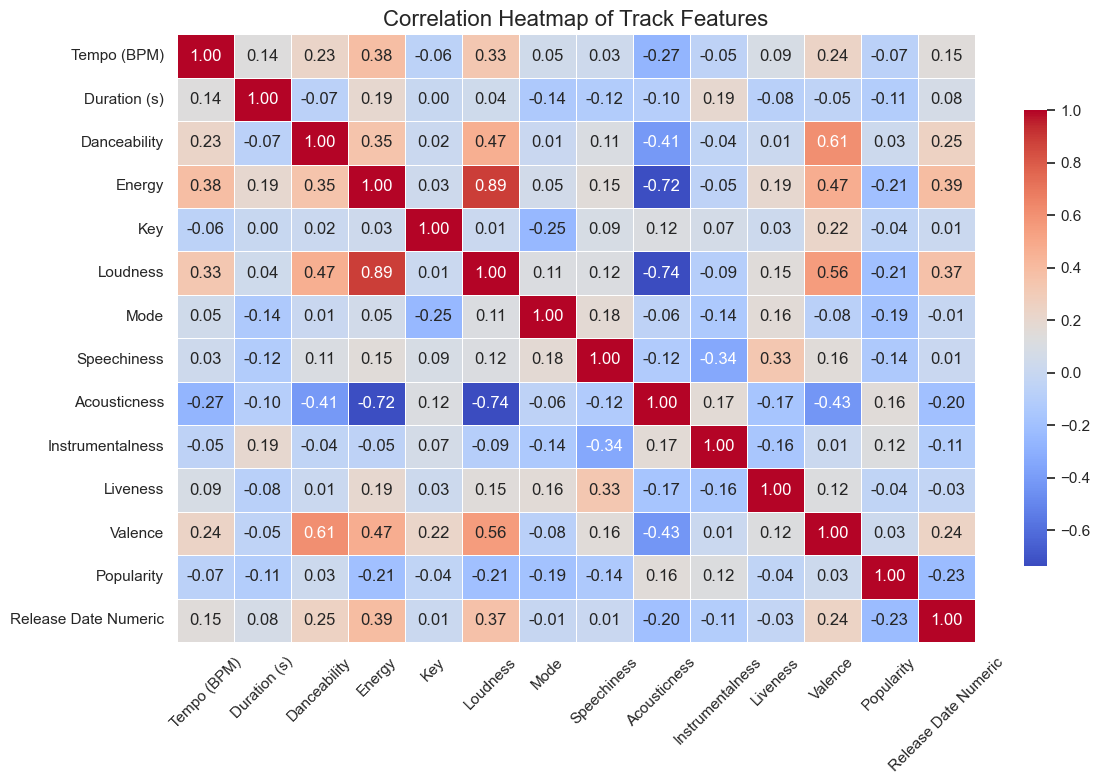

In [221]:
# Replace 'N/A' or 'No data' with NaN
df.replace({'N/A': pd.NA, 'No data': pd.NA}, inplace=True)

# Convert 'Release Date' to datetime format (assuming 'YYYY-MM-DD' format)
df['Release Date'] = pd.to_datetime(df['Release Date'], format='%Y-%m-%d', errors='coerce')

# Convert 'Release Date' to a numerical format (timestamp), handling NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

# Define the list of numeric columns
numeric_cols = ['Tempo (BPM)', 'Duration (s)', 'Danceability', 'Energy', 
                'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 
                'Instrumentalness', 'Liveness', 'Valence', 'Popularity', 'Release Date Numeric']

# Ensure these columns are numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Set the style of the visualization
sns.set(style='white')

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .75})

# Add titles and labels
plt.title('Correlation Heatmap of Track Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [227]:
# Convert 'N/A' or 'No data' to NaN
df.replace({'N/A': pd.NA, 'No data': pd.NA}, inplace=True)

# Convert 'Release Date' to datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Convert relevant columns to numeric
numeric_cols = ['Energy', 'Valence', 'Instrumentalness', 'Loudness', 'Acousticness']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert 'Release Date' to a numeric format (timestamp), handling NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

# Normalize 'Release Date' to be in the range [0, 1]
df['ReleaseDateNorm'] = (df['Release Date Numeric'] - df['Release Date Numeric'].min()) / (df['Release Date Numeric'].max() - df['Release Date Numeric'].min())

# Calculate the weight for Loudness
df['AdjustedLoudnessWeight'] = 1 - df['ReleaseDateNorm']

# Calculate the raw Bangerness score with adjusted Loudness weight
df['Bangerness'] = (9.9 * df['Energy'] +
                    0.1 * df['Valence'] +
                    0.2 * df['Instrumentalness'] +
                    0.1 * df['AdjustedLoudnessWeight'] * df['Loudness']) - df['Acousticness']

# Normalize the Bangerness score to the range [0, 1]
min_bangerness = df['Bangerness'].min()
max_bangerness = df['Bangerness'].max()
df['Bangerness'] = (df['Bangerness'] - min_bangerness) / (max_bangerness - min_bangerness)

# Sort DataFrame based on Bangerness
df_sorted = df.sort_values(['Bangerness'], ascending=False)

# Drop intermediate columns used for calculations
df_sorted = df_sorted.drop(columns=['ReleaseDateNorm', 'AdjustedLoudnessWeight', 'Release Date Numeric'])

# Extract the first word from 'Track Name'
df_sorted['First Word'] = df_sorted['Track Name'].str.split().str[0]

# Drop duplicates based on 'First Word', keeping the first occurrence
df_sorted_unique = df_sorted.drop_duplicates(subset='First Word', keep='first')

# Drop the 'First Word' column as it's no longer needed
df_sorted_unique = df_sorted_unique.drop(columns=['First Word'])

# Display the top 10 rows of the sorted and unique DataFrame
df_sorted_unique[['Track Name', 'Release Date', 'Tempo (BPM)', 'Instrumentalness', 
                  'Popularity', 'Danceability', 'Energy', 'Valence', 'Loudness', 
                  'Acousticness', 'Bangerness']].head(10)


,Track Name,Release Date,Tempo (BPM),Instrumentalness,Popularity,Danceability,Energy,Valence,Loudness,Acousticness,Bangerness
1,Flap Head - 2022 Remaster,2024-05-31,136.244,0.886,35,0.566,0.995,0.592,-7.022,0.15100,1.000000
7,Phloam - Cr7E Version,2024-05-31,132.169,0.477,24,0.536,0.979,0.191,-8.182,0.00102,0.990193
64,Carn Marth,1996-11-04,166.895,0.747,34,0.599,0.997,0.585,-3.264,0.05250,0.985794
5,"Digeridoo - Cr7E Version, Live In Cornwall",2024-05-31,142.803,0.900,26,0.525,0.986,0.370,-8.186,0.55500,0.961432
17,CIRCLONT14 [152.97][shrymoming mix],2014-09-22,152.969,0.928,34,0.671,0.978,0.178,-7.304,0.27900,0.958732
37,54 Cymru Beats,2001-10-22,168.012,0.694,35,0.632,0.967,0.390,-6.048,0.01640,0.953008
76,Start As You Mean To Go On,1995-04-24,150.950,0.926,29,0.610,0.992,0.542,-8.606,0.00235,0.950830
48,Afx237 v.7,2001-10-22,168.100,0.632,32,0.635,0.975,0.211,-7.318,0.01870,0.949827
23,Vordhosbn,2001-10-22,170.071,0.865,44,0.662,0.960,0.605,-6.619,0.04790,0.946607
67,Yellow Calx,1996-11-04,166.953,0.828,37,0.291,0.964,0.541,-6.704,0.15800,0.932064


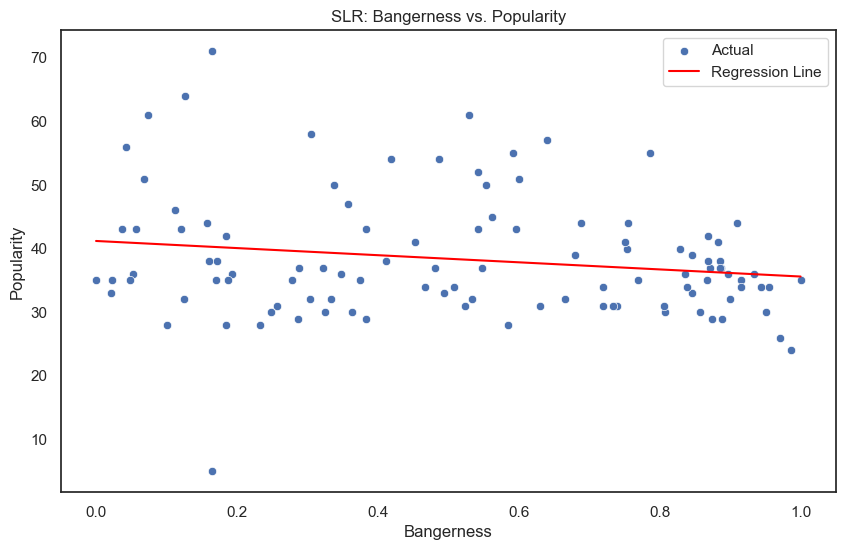

Coefficient (Slope): -5.587153761501626
Intercept: 41.186358039778845
Mean Squared Error (MSE): 88.5283956413681


In [129]:
# Ensure there are no NaN values in the columns
df_sorted_unique = df_sorted_unique.dropna(subset=['Bangerness', 'Popularity'])

# Reshape data for SLR
X = df_sorted_unique[['Bangerness']].values.reshape(-1, 1)  # Bangerness as predictor
y = df_sorted_unique['Popularity'].values  # Popularity as target

# Perform Simple Linear Regression
model = LinearRegression()
model.fit(X, y)

# Predicted values
y_pred = model.predict(X)

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bangerness', y='Popularity', data=df_sorted_unique, label='Actual')
plt.plot(df_sorted_unique['Bangerness'], y_pred, color='red', label='Regression Line')
plt.title('SLR: Bangerness vs. Popularity')
plt.xlabel('Bangerness')
plt.ylabel('Popularity')
plt.legend()
plt.show()

# Output the SLR results
print(f"Coefficient (Slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"Mean Squared Error (MSE): {np.mean((y_pred - y) ** 2)}")


In [130]:
df_sorted = df.sort_values(['Popularity'], ascending=False)
df_sorted.head(10)
df_sorted[['Track Name', 'Popularity', 'Tempo (BPM)', 'Duration (s)', 
            'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
            'Speechiness', 'Acousticness', 'Instrumentalness', 
            'Liveness', 'Valence', 'Release Date', 'Bangerness']].head(10)

,Track Name,Popularity,Tempo (BPM),Duration (s),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Release Date,Bangerness
40,QKThr,71,79.042,87.467,0.451,0.0223,1.0,-26.117,1.0,0.0461,0.99300,0.768,0.1300,0.0573,2001-10-22,0.165096
30,Avril 14th,64,157.811,125.520,0.558,0.0259,8.0,-30.016,1.0,0.0458,0.99600,0.871,0.0969,0.3700,2001-10-22,0.125910
106,Xtal,61,114.532,293.752,0.510,0.5050,9.0,-13.053,0.0,0.0344,0.34200,0.960,0.1170,0.3180,1992-02-10,0.529936
84,#3,61,146.977,464.293,0.159,0.0710,6.0,-27.109,0.0,0.0409,0.91100,0.856,0.1070,0.0602,1994-03-07,0.073814
21,aisatsana [102],58,101.390,321.880,0.260,0.0100,4.0,-32.894,0.0,0.0359,0.98000,0.843,0.1310,0.0349,2014-09-22,0.305200
53,Flim,57,147.980,177.093,0.710,0.7340,0.0,-14.932,0.0,0.0520,0.51300,0.836,0.0701,0.4000,1997-10-06,0.640481
110,I,56,76.923,77.347,0.183,0.0896,2.0,-27.540,1.0,0.0486,0.98900,0.899,0.1070,0.0326,1992-02-10,0.041872
79,Alberto Balsalm,55,93.988,310.747,0.791,0.5990,3.0,-13.648,1.0,0.1450,0.31500,0.928,0.1110,0.5700,1995-04-24,0.591563
14,180db_ [130],55,130.064,191.467,0.828,0.6100,1.0,-7.305,1.0,0.0648,0.00104,0.894,0.0792,0.5660,2014-09-22,0.786664
108,Pulsewidth,54,119.319,228.053,0.765,0.4860,1.0,-14.671,1.0,0.0724,0.42000,0.876,0.3320,0.3030,1992-02-10,0.486646


In [131]:
df_pop = df_sorted.head(10)

Mean Squared Error: 12.90411659354638
R² Score: 0.47883212465483116


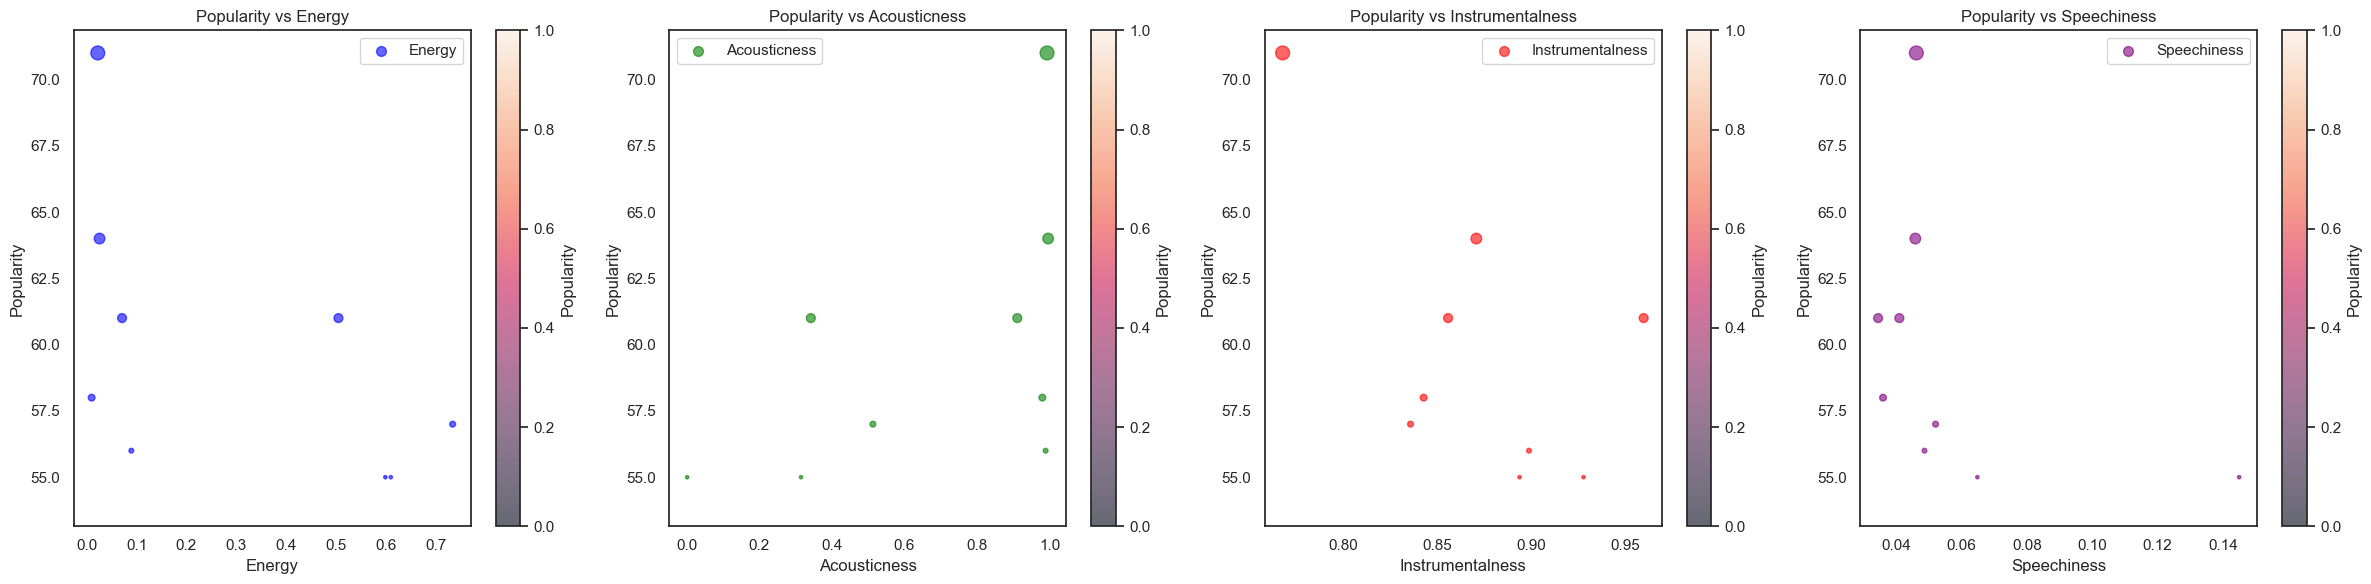

In [132]:
# Prepare the data
X = df_pop[['Energy', 'Acousticness', 'Instrumentalness', 'Speechiness']].values
y = df_pop['Popularity'].values

# Handle missing values and scale features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Impute missing values
X = imputer.fit_transform(X)

# Scale features
X = scaler.fit_transform(X)

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Scaling for dot sizes
popularity_scaled = (y - y.min()) / (y.max() - y.min()) * 100  # Scale to range 0-100

# Plotting
plt.figure(figsize=(24, 6))

# Scatter plot for Energy vs Popularity
plt.subplot(1, 4, 1)
plt.scatter(df_pop['Energy'], y, c='blue', s=popularity_scaled, alpha=0.6, label='Energy')
plt.xlabel('Energy')
plt.ylabel('Popularity')
plt.title('Popularity vs Energy')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Acousticness vs Popularity
plt.subplot(1, 4, 2)
plt.scatter(df_pop['Acousticness'], y, c='green', s=popularity_scaled, alpha=0.6, label='Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.title('Popularity vs Acousticness')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Instrumentalness vs Popularity
plt.subplot(1, 4, 3)
plt.scatter(df_pop['Instrumentalness'], y, c='red', s=popularity_scaled, alpha=0.6, label='Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Popularity')
plt.title('Popularity vs Instrumentalness')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Speechiness vs Popularity
plt.subplot(1, 4, 4)
plt.scatter(df_pop['Speechiness'], y, c='purple', s=popularity_scaled, alpha=0.6, label='Speechiness')
plt.xlabel('Speechiness')
plt.ylabel('Popularity')
plt.title('Popularity vs Speechiness')
plt.colorbar(label='Popularity')
plt.legend()

plt.tight_layout()
plt.show()


In [205]:
# Ensure all relevant columns are numeric
df_sorted_unique['Energy'] = pd.to_numeric(df_sorted_unique['Energy'], errors='coerce')
df_sorted_unique['Acousticness'] = pd.to_numeric(df_sorted_unique['Acousticness'], errors='coerce')
df_sorted_unique['Instrumentalness'] = pd.to_numeric(df_sorted_unique['Instrumentalness'], errors='coerce')
df_sorted_unique['Speechiness'] = pd.to_numeric(df_sorted_unique['Speechiness'], errors='coerce')
df_sorted_unique['Liveness'] = pd.to_numeric(df_sorted_unique['Liveness'], errors='coerce')

# Handle potential NaN values by filling them with the median of the respective columns
df_sorted_unique.fillna({
    'Energy': df_sorted_unique['Energy'].median(),
    'Acousticness': df_sorted_unique['Acousticness'].median(),
    'Instrumentalness': df_sorted_unique['Instrumentalness'].median(),
    'Speechiness': df_sorted_unique['Speechiness'].median(),
    'Liveness': df_sorted_unique['Liveness'].median()
}, inplace=True)

# Invert the scales where lower values should contribute positively to Ambientness
df_sorted_unique['Energy_inverse'] = 1 - df_sorted_unique['Energy']
df_sorted_unique['Speechiness_inverse'] = 1 - df_sorted_unique['Speechiness']
df_sorted_unique['Liveness_inverse'] = 1 - df_sorted_unique['Liveness']

# Calculate the Ambientness score
df_sorted_unique['Ambientness'] = (
    0.25 * df_sorted_unique['Energy_inverse'] +    # Low energy contributes positively
    0.25 * df_sorted_unique['Acousticness'] +      # High acousticness contributes positively
    0.25 * df_sorted_unique['Instrumentalness'] +  # High instrumentalness contributes positively
    0.15 * df_sorted_unique['Speechiness_inverse'] + # Low speechiness contributes positively
    0.10 * df_sorted_unique['Liveness_inverse']    # Low liveness contributes positively
)

# Normalize the Ambientness score to the range [0, 1]
min_ambientness = df_sorted_unique['Ambientness'].min()
max_ambientness = df_sorted_unique['Ambientness'].max()
df_sorted_unique['Ambientness'] = (df_sorted_unique['Ambientness'] - min_ambientness) / (max_ambientness - min_ambientness)

# Display the DataFrame with the new Ambientness column
df_sorted_unique[['Track Name', 'Energy', 'Acousticness', 'Instrumentalness', 
                  'Speechiness', 'Liveness', 'Ambientness']].head(20)
df_amb = df_sorted_unique.sort_values(['Ambientness'], ascending = False)
df_amb[['Album Name', 'Track Name', 'Popularity', 'Energy', 'Acousticness', 'Instrumentalness', 
                  'Speechiness', 'Liveness', 'Bangerness','Valence', 'Ambientness']].head(10)

,Album Name,Track Name,Popularity,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Bangerness,Valence,Ambientness
88,Selected Ambient Works Volume II,#7,43,0.03330,0.994,0.981,0.0371,0.0928,0.034418,0.0481,1.000000
46,Drukqs,Petiatil Cx Htdui,43,0.00682,0.996,0.956,0.0391,0.1540,0.115914,0.1390,0.992045
87,Selected Ambient Works Volume II,#6,35,0.07740,0.995,0.979,0.0423,0.0823,0.045093,0.0675,0.984226
44,Drukqs,Father,30,0.03210,0.990,0.951,0.0623,0.0851,0.236048,0.2030,0.983932
92,Selected Ambient Works Volume II,#11,35,0.02870,0.995,0.923,0.0409,0.0955,0.000000,0.0382,0.980018
26,Drukqs,Strotha Tynhe,38,0.00250,0.990,0.894,0.0610,0.0951,0.157787,0.0373,0.972959
95,Selected Ambient Works Volume II,#14,35,0.02960,0.992,0.946,0.0502,0.1900,0.020736,0.0377,0.971318
42,Drukqs,Bit 4,5,0.02320,0.972,0.930,0.0342,0.1400,0.150942,0.0000,0.971318
101,Selected Ambient Works Volume II,#20,51,0.04190,0.971,0.909,0.0418,0.0520,0.064476,0.0429,0.967713
104,Selected Ambient Works Volume II,#23,28,0.06710,0.996,0.909,0.0457,0.0790,0.090808,0.0391,0.962932


Mean Squared Error: 0.01671130347771379
R² Score: 0.783504506111329


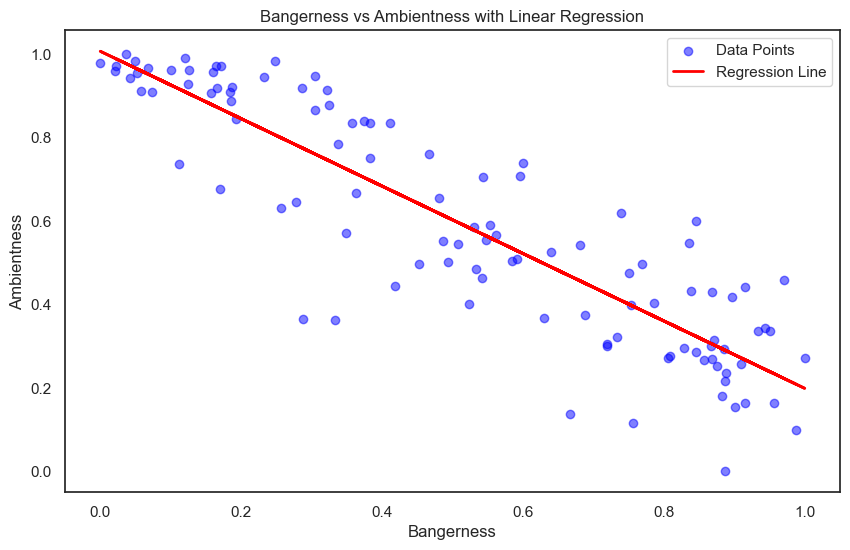

In [137]:
# Prepare the data
X = df_amb['Bangerness'].values.reshape(-1, 1)  # Independent variable
y = df_amb['Ambientness'].values  # Dependent variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Data Points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Bangerness')
plt.ylabel('Ambientness')
plt.title('Bangerness vs Ambientness with Linear Regression')
plt.legend()
plt.show()
